In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

train_df = pd.read_csv('sign_mnist_train.csv')
test_df = pd.read_csv('sign_mnist_test.csv')

2023-04-27 12:37:34.636578: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-27 12:37:34.691880: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-27 12:37:35.955710: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
x_train = train_df.iloc[:,train_df.columns != 'label']
y_train = train_df.iloc[:,train_df.columns == 'label']
y_train = y_train.values.reshape(-1)

x_test = test_df.iloc[:,test_df.columns != 'label']
y_test = test_df.iloc[:,test_df.columns == 'label']
y_test = y_test.values.reshape(-1)

In [3]:
x_train, x_train_test, y_train, y_train_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [6]:
from PIL import Image

train_data = np.array(x_train).reshape(-1, 28, 28, 1)
train_data = np.repeat(train_data, 3, axis=-1)
train_data= np.array([np.resize(img, (32, 32, 3)) for img in train_data])

train_test_data = np.array(x_train_test).reshape(-1, 28, 28, 1)
train_test_data = np.repeat(train_test_data, 3, axis=-1)
train_test_data= np.array([np.resize(img, (32, 32, 3)) for img in train_test_data])

test_data = np.array(x_test).reshape(-1, 28, 28, 1)
test_data = np.repeat(test_data, 3, axis=-1)
test_data= np.array([np.resize(img, (32, 32, 3)) for img in test_data])


In [8]:
train_data = train_data / 255.0
train_test_data = train_test_data / 255.0
test_data = test_data / 255.0

In [9]:
train_labels = to_categorical(y_train, num_classes=26)
train_test_labels = to_categorical(y_train_test, num_classes=26)
test_labels = to_categorical(y_test, num_classes=26)

In [12]:
train_test_labels.shape

(5491, 26)

In [13]:
Dense_model = DenseNet121(include_top=False, input_shape=(32, 32, 3), weights='imagenet')
x = Flatten()(Dense_model.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(26, activation='softmax')(x)
model = Model(inputs=Dense_model.input, outputs=predictions)

2023-04-27 12:38:52.903725: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-04-27 12:38:52.903758: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: gpu1.ada.davidson.edu
2023-04-27 12:38:52.903764: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: gpu1.ada.davidson.edu
2023-04-27 12:38:52.903856: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 530.30.2
2023-04-27 12:38:52.903874: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 530.30.2
2023-04-27 12:38:52.903879: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 530.30.2


In [14]:
opt = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

model.fit(train_data, train_labels, batch_size=32, epochs=10, validation_data=(train_test_data, train_test_labels))

test_loss, test_acc = model.evaluate(train_test_data, train_test_labels)
print('Test accuracy:', test_acc)

Epoch 1/10
687/687 [==============================] - 226s 281ms/step - loss: 0.7231 - accuracy: 0.7878 - val_loss: 0.9535 - val_accuracy: 0.7864
Epoch 2/10
687/687 [==============================] - 189s 275ms/step - loss: 0.1323 - accuracy: 0.9622 - val_loss: 0.3366 - val_accuracy: 0.9062
Epoch 3/10
687/687 [==============================] - 188s 273ms/step - loss: 0.0909 - accuracy: 0.9756 - val_loss: 0.5993 - val_accuracy: 0.8445
Epoch 4/10
687/687 [==============================] - 161s 234ms/step - loss: 0.0890 - accuracy: 0.9769 - val_loss: 0.1541 - val_accuracy: 0.9534
Epoch 5/10
687/687 [==============================] - 172s 250ms/step - loss: 0.0537 - accuracy: 0.9851 - val_loss: 0.3247 - val_accuracy: 0.9230
Epoch 6/10
687/687 [==============================] - 178s 258ms/step - loss: 0.0629 - accuracy: 0.9840 - val_loss: 0.4209 - val_accuracy: 0.8971
Epoch 7/10
687/687 [==============================] - 189s 276ms/step - loss: 0.0406 - accuracy: 0.9879 - val_loss: 0.0164 -

In [15]:
import tensorflow as tf
y_pred_labels = np.argmax(model.predict(test_data), axis=1)
y_true_labels = np.argmax(test_labels, axis=1)

225/225 [==============================] - 17s 64ms/step


In [21]:
final_loss, final_acc = model.evaluate(test_data, test_labels)
print(final_acc)

225/225 [==============================] - 13s 60ms/step - loss: 3.5668 - accuracy: 0.4628
0.4627718925476074


In [18]:
import sklearn.metrics as metrics

confusion_matrix = metrics.confusion_matrix(y_true=y_true_labels, y_pred=y_pred_labels) 

<AxesSubplot:>

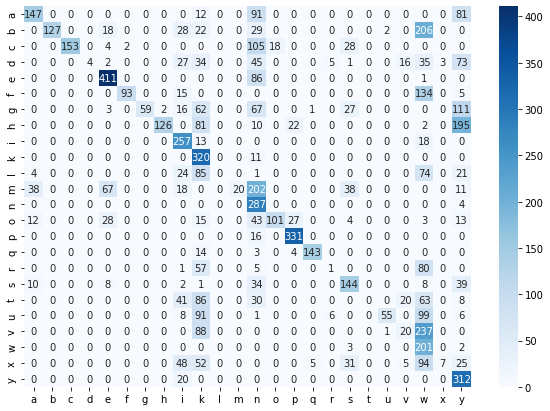

In [22]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

labels = []
for i in range(0,26):
    if(i != 9 and i!=25):
        labels.append(chr(i+97))
df_cm = pd.DataFrame(confusion_matrix, index = [i for i in labels],
                  columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')